# PythonEEG

In [22]:
%%script true
!jupyter nbconvert --to script pythoneeg.ipynb --TagRemovePreprocessor.remove_cell_tags='{"note"}' --output-dir .\pythoneeg\ --output core
    
# import PyInstaller.__main__
# if CONVERT_PY_TO_EXE:
#     # PyInstaller.__main__.run([
#     #     r'.\pys\pythoneeg.py',
#     #     r'--additional-hooks-dir',
#     #     r'.\extra-hooks',
#     #     r'--onefile',
#     #     r'--windowed',
#     # ])
#     PyInstaller.__main__.run([
#         r'.\pys\pythoneeg.py',
#         r'options.spec',
#     ])


[NbConvertApp] Converting notebook pythoneeg.ipynb to script
[NbConvertApp] Writing 34719 bytes to pythoneeg\core.py
C:\Users\dongjp\AppData\Local\Programs\Python\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  del self._target, self._args, self._kwargs
C:\Users\dongjp\AppData\Local\Programs\Python\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  del self._target, self._args, self._kwargs
C:\Users\dongjp\AppData\Local\Programs\Python\Python312\Lib\threading.py:1016: ResourceWarning: unclosed file <_io.BufferedReader name=11>
  del self._target, self._args, self._kwargs


In [1]:
import os
import warnings
import sys
from pathlib import Path
import gzip
import tempfile
import glob
import math
import re
from datetime import datetime, timedelta
import statistics
import time

import numpy as np
import matplotlib.pyplot as plt
# from scipy import signal, integrate
from scipy.integrate import simpson
from scipy.signal import welch, decimate
from scipy.interpolate import PchipInterpolator, Akima1DInterpolator, CubicSpline
from scipy.stats import linregress, pearsonr
import pandas as pd
from mne.time_frequency import psd_array_multitaper, csd_array_fourier, fwhm
from mne import set_config
from mne_connectivity import envelope_correlation, spectral_connectivity_time
from pactools import raw_to_mask, simulate_pac, Comodulogram, MaskIterator

from mountainsort5 import Scheme2SortingParameters, sorting_scheme2
from mountainsort5.util import create_cached_recording
import spikeinterface.core as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
# import spikeinterface.sorters as ss
# import spikeinterface.postprocessing as spost
# import spikeinterface.qualitymetrics as sqm
# import spikeinterface.exporters as sexp
# import spikeinterface.comparison as scmp
# import spikeinterface.curation as scur
# import spikeinterface.sortingcomponents as sc
import spikeinterface.widgets as sw
import probeinterface as pi
# from probeinterface.plotting import plot_probe_group, plot_probe

# import PyQt5.QtWidgets as qw
# import PyQt5.QtCore as qc
# import pygwalker as pyg
import PyInstaller.__main__



In [2]:
from platform import python_version

print(python_version())

3.12.6


In [2]:
# df = pd.read_csv("https://kanaries-app.s3.ap-northeast-1.amazonaws.com/public-datasets/bike_sharing_dc.csv", parse_dates=['date'])
# htmlstring = pyg.to_html(df)
# df = df.head()

# with open("html_pyg_walker.html", "w") as hf:
    # hf.write(htmlstring)

## Define Metadata Loader

In [3]:
def convert_units_to_multiplier(current_units, target_units='µV'):
    units_to_mult = {'µV' : 1e-6,
                     'mV' : 1e-3,
                     'V' : 1,
                     'nV' : 1e-9}
    
    assert current_units in units_to_mult.keys(), f"No valid current unit called '{current_units}' found"
    assert target_units in units_to_mult.keys(), f"No valid target unit called '{target_units}' found"

    return units_to_mult[current_units] / units_to_mult[target_units]

def is_day(dt: datetime, sunrise=6, sunset=18):
    return sunrise <= dt.hour < sunset

In [4]:
class DDFBinaryMetadata:

    def __init__(self, metadata_path, verbose=False) -> None:
        self.metadata_path = metadata_path
        self.metadata_df = pd.read_csv(metadata_path)
        self.verbose = verbose
        if verbose > 0:
            print(self.metadata_df)

        self.n_channels = len(self.metadata_df.index)
        self.f_s = self.__getsinglecolval("SampleRate")
        self.V_units = self.__getsinglecolval("Units")
        self.mult_to_uV = convert_units_to_multiplier(self.V_units)
        self.precision = self.__getsinglecolval("Precision")
        self.dt_end: datetime
        self.dt_start: datetime
        if "LastEdit" in self.metadata_df.keys():
            self.dt_end = datetime.fromisoformat(self.__getsinglecolval("LastEdit"))
        else:
            self.dt_end = None
            warnings.warn("No LastEdit column provided in metadata. dt_end set to None")

        self.channel_to_info = self.metadata_df.loc[:, ["BinColumn", "ProbeInfo"]].set_index('BinColumn').T.to_dict('list')
        self.channel_to_info = {k:v[0] for k,v in self.channel_to_info.items()}
        self.id_to_info = {k-1:v for k,v in self.channel_to_info.items()}
        self.entity_to_info = self.metadata_df.loc[:, ["Entity", "ProbeInfo"]].set_index('Entity').T.to_dict('list')
        self.entity_to_info = {k:v[0] for k,v in self.entity_to_info.items()}
        self.channel_names = list(self.channel_to_info.values())

        # TODO read probe geometry information, may be user-defined

    def __getsinglecolval(self, colname):
        vals = self.metadata_df.loc[:, colname]
        if len(np.unique(vals)) > 1:
            warnings.warn(f"Not all {colname}s are equal!")
        if vals.size == 0:
            return None
        return vals.iloc[0]


In [5]:
%%script false
tmpmet = DDFBinaryMetadata(r"Z:\PythonEEG Data Bins\A5 WT 12_12-2023\Cage 1 A5 -1_Meta.csv")
# tmpmet.dt_end.ctime()
tmpmet.channel_names

Couldn't find program: 'false'


## Define Analysis Pipeline

In [6]:
def convert_ddfcolbin_to_ddfrowbin(rowdir_path, colbin_path, metadata, save_gzip=True):
    assert isinstance(metadata, DDFBinaryMetadata), "Metadata needs to be of type DDFBinaryMetadata"
    
    tempbin = np.fromfile(colbin_path, dtype=metadata.precision)
    tempbin = np.reshape(tempbin, (-1, metadata.n_channels), order='F')

    # rowbin_path = Path(colbin_path).parent / f'{Path(colbin_path).stem.replace("ColMajor", "RowMajor")}'
    rowbin_path = convert_colpath_to_rowpath(rowdir_path, colbin_path, gzip=save_gzip)

    if save_gzip:
        # rowbin_path = str(rowbin_path) + ".npy.gz"
        with gzip.GzipFile(rowbin_path, "w") as fcomp:
            np.save(file=fcomp, arr=tempbin)
    else:
        # rowbin_path = str(rowbin_path) + ".bin"
        tempbin.tofile(rowbin_path)
    
    return rowbin_path

def convert_colpath_to_rowpath(rowdir_path, col_path, gzip=True, aspath=True):
    out = Path(rowdir_path) / f'{Path(col_path).stem.replace("ColMajor", "RowMajor")}'
    if gzip:
        out = str(out) + ".npy.gz"
    else:
        out = str(out) + ".bin"
    return Path(out) if aspath else out

def convert_ddfrowbin_to_si(bin_rowmajor_path, metadata):
    # 1-file .MAT containing entire recording trace
    # Returns as SpikeInterface Recording structure
    assert isinstance(metadata, DDFBinaryMetadata), "Metadata needs to be of type DDFBinaryMetadata"

    bin_rowmajor_path = Path(bin_rowmajor_path)
    params = {"sampling_frequency" : metadata.f_s,
              "dtype" : metadata.precision,
              "num_channels" : metadata.n_channels,
              "gain_to_uV" : metadata.mult_to_uV,
              "time_axis" : 0,
              "is_filtered" : False}

    # Read either .npy.gz files or .bin files into the recording object
    if ".npy.gz" in str(bin_rowmajor_path):
        temppath = os.path.join(tempfile.gettempdir(), os.urandom(24).hex())
        print(f"Opening tempfile {temppath}")
        with open(temppath, "wb") as tmp:
            fcomp = gzip.GzipFile(bin_rowmajor_path, "r")
            bin_rowmajor_decomp = np.load(fcomp)
            bin_rowmajor_decomp.tofile(tmp)

            rec = se.read_binary(tmp.name, **params)
    else:
        rec = se.read_binary(bin_rowmajor_path, **params)
        temppath = None

    return rec, temppath


In [7]:
def filepath_to_index(filepath) -> int:
    fpath = str(filepath)
    for suffix in ['_RowMajor', '_ColMajor', '_Meta']:
        fpath = fpath.replace(suffix, '')
    fpath = fpath.removesuffix(''.join(Path(fpath).suffixes))
    fname = Path(fpath).name
    fname = re.split(r'\D+', fname)
    fname = list(filter(None, fname))
    return int(fname[-1])


In [8]:
class HiddenPrints:
    def __init__(self, silence=True) -> None:
        self.silence = silence

    def __enter__(self):
        if self.silence:
            self._original_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.silence:
            sys.stdout.close()
            sys.stdout = self._original_stdout

In [9]:
class LongRecordingOrganizer:
    def __init__(self, base_folder_path, 
                 colbin_folder_path=None,
                 rowbin_folder_path=None,
                 metadata_path=None,
                 truncate=False) -> None:
        
        if type(truncate) is int:
            self.truncate = True
            self.n_truncate = truncate
        elif type(truncate) is bool:
            self.truncate = truncate
            self.n_truncate = 10
        else:
            self.truncate = False
            warnings.warn("Invalid truncate parameter, setting truncate = False")
        if self.truncate:
            warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")

        self.base_folder_path = Path(base_folder_path)

        self.colbin_folder_path = self.base_folder_path if colbin_folder_path is None else Path(colbin_folder_path)
        os.makedirs(self.colbin_folder_path, exist_ok=True)
        self.rowbin_folder_path = self.colbin_folder_path if rowbin_folder_path is None else Path(rowbin_folder_path)
        os.makedirs(self.rowbin_folder_path, exist_ok=True)

        self.__update_colbins_rowbins_metas()

        if metadata_path is not None:
            self.meta = DDFBinaryMetadata(metadata_path)
            self.metadata_objects = [self.meta]
        else:
            self.meta = DDFBinaryMetadata(self.metas[0])
            self.metadata_objects = [DDFBinaryMetadata(x) for x in self.metas]
            self._validate_metadata_consistency(self.metadata_objects)
        self.channel_names = self.meta.channel_names

        dt_ends = [x.dt_end for x in self.metadata_objects]
        if all(x is None for x in dt_ends):
            raise ValueError("No dates found in any metadata object!")
        
        self._median_datetime = statistics.median_low(pd.Series(dt_ends).dropna())
        self._idx_median_datetime = dt_ends.index(self._median_datetime)

    def __truncate_lists(self, colbins, rowbins, metas):
        if len(colbins) > self.n_truncate:
            out_colbins = colbins[:self.n_truncate]
        else:
            out_colbins = colbins

        out_rowbins = []
        out_metas = []
        for i, e in enumerate(rowbins):
            tempcolname = Path(e).name.replace("RowMajor.npy.gz", "ColMajor.bin")
            if str(self.colbin_folder_path / tempcolname) in out_colbins:
                out_rowbins.append(e)
        for i, e in enumerate(metas):
            tempcolname = Path(e).name.replace("Meta.csv", "ColMajor.bin")
            if str(self.colbin_folder_path / tempcolname) in out_colbins:
                out_metas.append(e)

        return out_colbins, out_rowbins, out_metas

    def __update_colbins_rowbins_metas(self):
        self.colbins = glob.glob(str(self.colbin_folder_path / "*_ColMajor.bin"))
        self.rowbins = glob.glob(str(self.rowbin_folder_path / "*_RowMajor.npy.gz"))
        self.metas = glob.glob(str(self.colbin_folder_path / "*_Meta.csv"))

        self.colbins.sort(key=filepath_to_index)
        self.rowbins.sort(key=filepath_to_index)
        self.metas.sort(key=filepath_to_index)

        metadatas = [DDFBinaryMetadata(x) for x in self.metas]
        for meta in metadatas:
            if meta.metadata_df.empty:
                searchstr = Path(meta.metadata_path).name.replace("_Meta", "")
                self.colbins = [x for x in self.colbins if searchstr not in x]
                self.rowbins = [x for x in self.rowbins if searchstr not in x]
                self.metas = [x for x in self.metas if searchstr not in x]

        if self.truncate:
            self.colbins, self.rowbins, self.metas = self.__truncate_lists(self.colbins, self.rowbins, self.metas)

    def _validate_metadata_consistency(self, metadatas:list[DDFBinaryMetadata]):
        meta0 = metadatas[0]
        attributes = ['f_s', 'n_channels', 'precision', 'V_units', 'channel_names']
        for attr in attributes:
            if not all([getattr(meta0, attr) == getattr(x, attr) for x in metadatas]):
                raise ValueError(f"Metadata files inconsistent at attribute {attr}")
        return


    def convert_colbins_to_rowbins(self, overwrite=True):
        if not overwrite and self.rowbins:
            warnings.warn("Row-major binary files already exist! Skipping existing files")
            # else:
            #     raise FileExistsError("Row-major binary files already exist! overwrite=False")
        for i, e in enumerate(self.colbins):
            if convert_colpath_to_rowpath(self.rowbin_folder_path, e, aspath=False) not in self.rowbins or overwrite:
                print(f"Converting {e}")
                convert_ddfcolbin_to_ddfrowbin(self.rowbin_folder_path, e, self.meta)
        self.__update_colbins_rowbins_metas()

    def convert_rowbins_to_rec(self):
        recs = []
        self.end_relative = []
        t_to_median = 0
        t_cumulative = 0
        self.temppaths = []
        for i, e in enumerate(self.rowbins):
            print(f"Reading {e}")
            rec, temppath = convert_ddfrowbin_to_si(e, self.meta)
            recs.append(rec)
            self.temppaths.append(temppath)

            if i <= self._idx_median_datetime:
                t_to_median += rec.get_duration()
            t_cumulative += rec.get_duration()
            self.end_relative.append(t_cumulative)

        self.LongRecording = si.concatenate_recordings(recs)
        self.start_datetime = self._median_datetime - timedelta(seconds=t_to_median)

    def cleanup_rec(self):
        try:
            del self.LongRecording
        except AttributeError:
            warnings.warn("LongRecording does not exist, probably deleted already")
        for tpath in self.temppaths:
            Path.unlink(tpath)

    def get_num_fragments(self, fragment_len_s):
        frag_len_idx = self.__time_to_idx(fragment_len_s)
        duration_idx = self.LongRecording.get_num_frames()
        return math.ceil(duration_idx / frag_len_idx)

    def __time_to_idx(self, time_s):
        return self.LongRecording.time_to_sample_index(time_s)
    
    def __idx_to_time(self, idx):
        return self.LongRecording.sample_index_to_time(idx)

    def get_fragment(self, fragment_len_s, fragment_idx):
        startidx, endidx = self.__fragidx_to_startendind(fragment_len_s, fragment_idx)
        return self.LongRecording.frame_slice(startidx, endidx)
    
    def get_dur_fragment(self, fragment_len_s, fragment_idx):
        startidx, endidx = self.__fragidx_to_startendind(fragment_len_s, fragment_idx)
        return self.__idx_to_time(endidx) - self.__idx_to_time(startidx)
    
    def get_datetime_fragment(self, fragment_len_s, fragment_idx):
        idx, _ = self.__fragidx_to_startendind(fragment_len_s, fragment_idx)
        return self.start_datetime + timedelta(seconds=self.__idx_to_time(idx))
        
    def __fragidx_to_startendind(self, fragment_len_s, fragment_idx):
        frag_len_idx = self.__time_to_idx(fragment_len_s)
        startidx = frag_len_idx * fragment_idx
        endidx = min(frag_len_idx * (fragment_idx + 1), self.LongRecording.get_num_frames())
        return startidx, endidx

In [10]:
class MountainSortOrganizer:
    def __init__(self, recording, plot_probe=False, verbose=False, n_jobs: None | int = None) -> None:
        assert isinstance(recording, si.BaseRecording)
        self.recording = recording
        # self.notch_filter = 60 # Hz
        self.n_channels = recording.get_num_channels()
        self.verbose = verbose
        if n_jobs is not None:
            si.set_global_job_kwargs(n_jobs=n_jobs) # n_jobs = -1 => use all cores (may be slower)
        
        # Create a dummy probe
        linprobe = pi.generate_linear_probe(self.n_channels, ypitch=40)
        linprobe.set_device_channel_indices(self.recording.get_channel_ids())
        linprobe.set_contact_ids(self.recording.get_channel_ids())
        self.recording = self.recording.set_probe(linprobe)

        # Visualize
        if plot_probe:
            _, ax2 = plt.subplots(1, 1)
            plot_probe(linprobe, ax=ax2, with_device_index=True, with_contact_id=True)
            plt.show()

    def preprocess_recording(self, freq_min=100):
        rec_prep = spre.common_reference(self.recording)
        rec_prep = spre.scale(rec_prep, gain=10) # Scaling for whitening to work properly
        rec_prep = spre.whiten(rec_prep)
        rec_prep = spre.highpass_filter(rec_prep, freq_min=freq_min, ftype='bessel')
        # rec_prep = spre.bandpass_filter(rec_prep, freq_min=freq_min, freq_max=freq_max, ftype='bessel')
        # rec_preps = []
        # for i in range(self.n_channels):
        #     rec_preps.append(rec_prep.remove_channels(np.delete(np.arange(self.n_channels), i)))
        # rec_prep = rec_prep.remove_channels(np.arange(1, 8)) # Experimental, remove all channels except one
        # self.prep_recordings = rec_preps
        self.prep_recording = rec_prep
    
    def extract_spikes(self, snippet_T=0.1):
        snippet_samples = round(self.recording.sampling_frequency * snippet_T)
        temp_dir = Path(tempfile.gettempdir()) / os.urandom(24).hex()
        os.makedirs(temp_dir)
        sort_params = Scheme2SortingParameters(
            phase1_detect_channel_radius=1, 
            detect_channel_radius=1, 
            snippet_T1=snippet_samples, 
            snippet_T2=snippet_samples,
            )
        
        recording_cached = create_cached_recording(self.prep_recording, folder=temp_dir)

        with HiddenPrints(silence=not self.verbose):
            # Sort over all channels
            self.sorting = sorting_scheme2(
                recording=recording_cached,
                sorting_parameters=sort_params
            )
            # Sort on individual channels
            self.sortings = []
            for i in range(self.n_channels):
                sorting = sorting_scheme2(
                            recording=recording_cached.remove_channels(np.delete(np.arange(self.n_channels), i)),
                            sorting_parameters=sort_params
                        )
                self.sortings.append(sorting)

    def preprocess_final_recording(self, notch_freq=60):
        rec_prep = spre.notch_filter(self.recording, freq=notch_freq) # Get rid of mains hum
        # rec_prep = spre.highpass_filter(rec_prep, freq_min=60, ftype='bessel')

        rec_preps = []
        for i in range(self.n_channels):
            rec_preps.append(rec_prep.remove_channels(np.delete(np.arange(self.n_channels), i)))
        self.prep_final_recording = rec_prep
        self.prep_final_recordings = rec_preps

    def get_final_analyzer(self, folder=None):
        if folder is None:
            folder = Path(tempfile.gettempdir()) / os.urandom(24).hex()
            os.makedirs(folder)
        # self.get_final_sorting()
        sorting_analyzers = []
        for i,e in enumerate(self.sortings):
            sorting_analyzers.append(si.create_sorting_analyzer(e, self.prep_final_recordings[i],
                                                                # folder=folder,
                                                                sparse=False,
                                                                overwrite=True))
        sorting_analyzer = si.create_sorting_analyzer(self.sorting, self.prep_final_recording, 
                                                    #   folder=folder, 
                                                      sparse=False, 
                                                      overwrite=True)
        
        self.sorting_analyzer = sorting_analyzer
        self.sorting_analyzers = sorting_analyzers
        return sorting_analyzer, sorting_analyzers


In [20]:
class LongRecordingAnalyzer:
    
    FEATURES = ['rms', 'ampvar', 'psd', 'psdtotal', 'psdband', 'psdslope', 'cohere', 'pcorr', 'nspike', 'wavetemp']
    GLOBAL_FEATURES = ['templates']
    FREQ_BANDS = {'delta' : (0.1, 4),
                'theta' : (4, 8),
                'alpha' : (8, 13),
                'beta'  : (13, 25),
                'gamma' : (25, 50)}
    FREQ_BAND_TOTAL = (0.1, 50)
    FREQ_MINS = [v[0] for k,v in FREQ_BANDS.items()]
    FREQ_MAXS = [v[1] for k,v in FREQ_BANDS.items()]
    FREQ_BAND_NAMES = list(FREQ_BANDS.keys())

    def __init__(self, longrecording, fragment_len_s=10, notch_freq=60) -> None:

        assert isinstance(longrecording, LongRecordingOrganizer)

        self.LongRecording = longrecording
        self.fragment_len_s = fragment_len_s
        self.n_fragments = longrecording.get_num_fragments(fragment_len_s)
        self.channel_to_info = longrecording.meta.channel_to_info
        self.channel_names = longrecording.channel_names
        self.n_channels = longrecording.meta.n_channels
        self.V_units = longrecording.meta.V_units
        self.mult_to_uV = longrecording.meta.mult_to_uV
        self.f_s = int(longrecording.meta.f_s)
        self.notch_freq = notch_freq
        

    def get_fragment_rec(self, index) -> si.BaseRecording:
        return self.LongRecording.get_fragment(self.fragment_len_s, index)

    def get_fragment_np(self, index, recobj=None) -> np.ndarray:
        assert isinstance(recobj, si.BaseRecording) or recobj is None
        if recobj is None:
            return self.get_fragment_rec(index).get_traces(return_scaled=True) # (num_samples, num_channels), in units uV
        else:
            return recobj.get_traces(return_scaled=True)

    # (1 epoch, num_channels, num_samples)
    def get_fragment_mne(self, index, recobj=None) -> np.ndarray:
        rec = self.get_fragment_np(index, recobj=recobj)[..., np.newaxis]
        return np.transpose(rec, (2, 1, 0))

    def compute_rms(self, index, **kwargs):
        rec = self.get_fragment_np(index)
        return np.sqrt((rec ** 2).sum(axis=0) / rec.shape[0])
    
    def compute_ampvar(self, index, **kwargs):
        rec = self.get_fragment_np(index)
        return np.std(rec, axis=0) ** 2
    
    def compute_psd(self, index, welch_bin_t=1, notch_filter=True, multitaper=False, n_jobs=None, **kwargs):
        rec = self.get_fragment_rec(index)
        if notch_filter:
            rec = spre.notch_filter(rec, freq=self.notch_freq, q=100)
        rec_np = rec.get_traces(return_scaled=True)

        if not multitaper:
            f, psd = welch(rec_np, fs=self.f_s, nperseg=round(welch_bin_t * self.f_s), axis=0)
            
            if index == self.n_fragments - 1 and self.n_fragments > 1:
                f_prev, _ = self.compute_psd(index - 1, welch_bin_t, notch_filter, multitaper)
                psd = Akima1DInterpolator(f, psd, axis=0, extrapolate=True)(f_prev)
                f = f_prev
        else:
            psd, f = psd_array_multitaper(rec_np.transpose(), self.f_s, fmax=self.FREQ_BAND_TOTAL[1],
                                            adaptive=True, n_jobs=n_jobs, normalization='full', low_bias=False, verbose=0)
            psd = psd.transpose()
        return f, psd
    
    def compute_psdband(self, index, welch_bin_t=1, notch_filter=True, bands=None, multitaper=False, f_psd=None, **kwargs):
        fbands = self.FREQ_BANDS if bands is None else bands
        if f_psd is not None:
            f, psd = f_psd
        else:
            f, psd = self.compute_psd(index, welch_bin_t, notch_filter, multitaper)
        deltaf = np.diff(f).mean()

        out = {}
        for k,v in fbands.items():
            out_v = simpson(psd[np.logical_and(f >= v[0], f <= v[1]), :], dx=deltaf, axis=0)
            out[k] = out_v
        return out
    
    def compute_psdtotal(self, index, welch_bin_t=1, notch_filter=True, band=None, multitaper=False, f_psd=None, **kwargs):
        fband = self.FREQ_BAND_TOTAL if band is None else band
        if f_psd is not None:
            f, psd = f_psd
        else:
            f, psd = self.compute_psd(index, welch_bin_t, notch_filter, multitaper)
        deltaf = np.diff(f).mean()

        return simpson(psd[np.logical_and(f >= fband[0], f <= fband[1]), :], dx=deltaf, axis=0)
    
    def compute_psdslope(self, index, welch_bin_t=1, notch_filter=True, band=None, multitaper=False, f_psd=None, **kwargs):
        fband = self.FREQ_BAND_TOTAL if band is None else band
        if f_psd is not None:
            f, psd = f_psd
        else:
            f, psd = self.compute_psd(index, welch_bin_t, notch_filter, multitaper)
        
        frange = np.logical_and(f >= fband[0], f <= fband[1])
        logf = np.log10(f[frange])
        logpsd = np.log10(psd[frange, :])

        out = []
        for i in range(logpsd.shape[1]):
            result = linregress(logf, logpsd[:, i], 'less')
            out.append((result.slope, result.intercept))
        return out

    # Needs work; will need to accept a geometry file to effectively find multielectrode events
    def compute_spikes(self, verbose=False, n_jobs_si: None | int = None, **kwargs):
        mso = MountainSortOrganizer(self.LongRecording.LongRecording, verbose=verbose, n_jobs=n_jobs_si)
        mso.preprocess_recording()
        mso.extract_spikes()
        mso.preprocess_final_recording()
        self.sorting_analyzer, self.sorting_analyzers = mso.get_final_analyzer()
        return self.sorting_analyzer, self.sorting_analyzers
    
    def compute_nspike(self, index, sa_sas=None, **kwargs):
        if sa_sas is None:
            if not hasattr(self, "sorting_analyzer") or not hasattr(self, "sorting_analyzers"):
                self.compute_spikes(**kwargs)
            sa_sas = (self.sorting_analyzer, self.sorting_analyzers)
        sa, sas = sa_sas
        assert isinstance(sa, si.SortingAnalyzer)
        for e in sas:
            assert isinstance(e, si.SortingAnalyzer)
        
        tbound = self.__frag_idx_to_timebound(index)
        nspike_unit = []
        if sa.get_num_units() > 0:
            for unit_id in sa.sorting.unit_ids:
                t_spike = sa.sorting.get_unit_spike_train(unit_id=unit_id) / self.f_s
                nspike_unit.append(((tbound[0] <= t_spike) & (t_spike < tbound[1])).sum())
        else:
            print("No units across all channels, skipping..")

        nspikes_unit = []
        for i,e in enumerate(sas):
            nspikes_unit.append([])
            if e.get_num_units() == 0:
                # print(f"No units in channel {i}, skipping..")
                continue
            for unit_id in e.sorting.unit_ids:
                t_spike = e.sorting.get_unit_spike_train(unit_id=unit_id) / self.f_s
                nspikes_unit[-1].append(((tbound[0] <= t_spike) & (t_spike < tbound[1])).sum())

        return nspikes_unit, nspikes_unit
        
    def __frag_idx_to_timebound(self, index):
        frag_len_idx = round(self.fragment_len_s * self.f_s)
        startidx = frag_len_idx * index
        endidx = min(frag_len_idx * (index + 1), self.LongRecording.LongRecording.get_num_frames())
        return (startidx / self.f_s, endidx / self.f_s)

    def compute_wavetemp(self, index, sa_sas=None, ms_before=200, ms_after=200, **kwargs):
        if sa_sas is None:
            if not hasattr(self, "sorting_analyzer") or not hasattr(self, "sorting_analyzers"):
                self.compute_spikes()
            sa_sas = (self.sorting_analyzer, self.sorting_analyzers)
        sa, sas = sa_sas
        assert isinstance(sa, si.SortingAnalyzer)
        for e in sas:
            assert isinstance(e, si.SortingAnalyzer)

        if hasattr(self, 'computed_sorting_analyzer') and hasattr(self, 'computed_sorting_analyzers'):
            return self.computed_sorting_analyzer, self.computed_sorting_analyzers
        else:
            if sa.get_num_units() > 0:
                sa.compute("random_spikes", max_spikes_per_unit=1000)
                sa.compute("waveforms", ms_before=ms_before, ms_after=ms_after)
                sa.compute("templates", operators=["average", "median", "std"])
            else:
                print("No units across all channels, skipping..")
            for i,e in enumerate(sas):
                if e.get_num_units() == 0:
                    # print(f"No units in channel {i}, skipping..")
                    continue
                e.compute("random_spikes", max_spikes_per_unit=1000)
                e.compute("waveforms", ms_before=ms_before, ms_after=ms_after)
                e.compute("templates", operators=["average", "median", "std"])

            self.computed_sorting_analyzer = sa
            self.computed_sorting_analyzers = sas
            return sa, sas

    def __get_freqs_cycles(self, index, freq_res, n_cycles_max, geomspace, mode:str, epsilon):
        if geomspace:
            freqs = np.geomspace(self.FREQ_BAND_TOTAL[0], self.FREQ_BAND_TOTAL[1], round((np.diff(self.FREQ_BAND_TOTAL) / freq_res).item()))
        else:
            freqs = np.arange(self.FREQ_BAND_TOTAL[0], self.FREQ_BAND_TOTAL[1], freq_res)

        frag_len_s = self.LongRecording.get_dur_fragment(self.fragment_len_s, index)
        match mode:
            case 'cwt_morlet':
                maximum_cyc = (frag_len_s * self.f_s + 1) * np.pi / 5 * freqs / self.f_s
                # print(fwhm(freqs, n_cycles_max))
            case 'multitaper':
                maximum_cyc = frag_len_s * freqs
            case _:
                raise ValueError(f"Invalid mode {mode}, pick 'cwt_morlet' or 'multitaper'")
        maximum_cyc = maximum_cyc - epsilon # Shave off a bit to avoid indexing errors
        n_cycles = np.minimum(np.full(maximum_cyc.shape, n_cycles_max), maximum_cyc)
        return freqs, n_cycles

    def compute_cohere(self, index, freq_res=1, n_cycles_max=7.0, geomspace=True, mode:str='cwt_morlet', downsamp_q=4, epsilon=1e-2, n_jobs_coh=None, **kwargs):
        rec = self.get_fragment_mne(index)
        rec = decimate(rec, q=downsamp_q, axis=-1)
        freqs, n_cycles = self.__get_freqs_cycles(index=index, freq_res=freq_res, n_cycles_max=n_cycles_max, geomspace=geomspace, mode=mode, epsilon=epsilon)
        try:
            con = spectral_connectivity_time(rec,
                                            freqs=freqs,
                                            method='coh',
                                            average=True,
                                            faverage=True,
                                            mode=mode,
                                            fmin=self.FREQ_MINS,
                                            fmax=self.FREQ_MAXS,
                                            sfreq=self.f_s / downsamp_q,
                                            n_cycles=n_cycles,
                                            n_jobs=n_jobs_coh,
                                            verbose=False)
        except MemoryError as e:
            raise MemoryError("Out of memory, use a larger freq_res parameter") from e
        data = con.get_data()
        out = {}
        for i in range(data.shape[1]):
            out[self.FREQ_BAND_NAMES[i]] = data[:, i].reshape((self.n_channels, self.n_channels))
        return out
    
    def compute_cacoh(self, index, freq_res=1, n_cycles_max=7.0, geomspace=True, mode:str='cwt_morlet', downsamp_q=4, epsilon=1e-2, mag_phase=True, indices=None, **kwargs):
        rec = self.get_fragment_mne(index)
        rec = decimate(rec, q=downsamp_q, axis=-1)
        freqs, n_cycles = self.__get_freqs_cycles(index=index, freq_res=freq_res, n_cycles_max=n_cycles_max, geomspace=geomspace, mode=mode, epsilon=epsilon)
        try:
            con = spectral_connectivity_time(rec,
                                            freqs=freqs,
                                            method='cacoh',
                                            average=True,
                                            mode=mode,
                                            fmin=self.FREQ_BAND_TOTAL[0],
                                            fmax=self.FREQ_BAND_TOTAL[1],
                                            sfreq=self.f_s / downsamp_q,
                                            n_cycles=n_cycles,
                                            indices=indices, # TODO implement L/R hemisphere coherence metrics
                                            verbose=False)
        except MemoryError as e:
            raise MemoryError("Out of memory, use a larger freq_res parameter") from e
        
        data:np.ndarray = con.get_data().squeeze()
        if mag_phase:
            return np.abs(data), np.angle(data, deg=True), con.freqs
        else:
            return data, con.freqs

    def compute_pcorr(self, index, lower_triag=True, **kwargs) -> np.ndarray:
        rec = spre.bandpass_filter(self.get_fragment_rec(index),
                                    freq_min=self.FREQ_BAND_TOTAL[0],
                                    freq_max=self.FREQ_BAND_TOTAL[1])
        rec = self.get_fragment_np(index, rec).transpose()
        result = pearsonr(rec[:, np.newaxis, :], rec, axis=-1)
        if lower_triag:
            return np.tril(result.correlation, k=-1)
        else:
            return result.correlation
    
    def compute_csd(self, index, magnitude=True, n_jobs=None, **kwargs) -> np.ndarray:
        rec = self.get_fragment_mne(index)
        csd = csd_array_fourier(rec, self.f_s, 
                                fmin=self.FREQ_BAND_TOTAL[0], 
                                fmax=self.FREQ_BAND_TOTAL[1], 
                                ch_names=self.channel_names,
                                n_jobs=n_jobs,
                                verbose=False)
        out = {}
        for k,v in self.FREQ_BANDS.items():
            try:
                csd_band = csd.mean(fmin=v[0], fmax=v[1]) # Breaks if slice is too short
            except (IndexError, UnboundLocalError):
                timebound = self.__frag_idx_to_timebound(index)
                warnings.warn(f"compute_csd failed for window {index}, {round(timebound[1]-timebound[0], 5)} s. Likely too short")
                data = self.compute_csd(index - 1, magnitude)[k]
            else:
                data = csd_band.get_data()
            finally:
                if magnitude:
                    out[k] = np.abs(data)
                else:
                    out[k] = data
        return out

    def compute_envcorr(self, index, **kwargs) -> np.ndarray:
        rec = spre.bandpass_filter(self.get_fragment_rec(index),
                                    freq_min=self.FREQ_BAND_TOTAL[0],
                                    freq_max=self.FREQ_BAND_TOTAL[1])
        rec = self.get_fragment_mne(index, rec)
        envcor = envelope_correlation(rec, self.channel_names)
        return envcor.get_data().reshape((self.n_channels, self.n_channels))
    
    def compute_pac(self, index):
        ... # TODO implement CFC measures
        

    def get_file_end(self, index, **kwargs):
        tstart, tend = self.__frag_idx_to_timebound(index)
        for tfile in self.LongRecording.end_relative:
           if tstart <= tfile < tend:
               return tfile - tstart
        return None 

    def setup_njobs(self):
        set_config('MNE_MEMMAP_MIN_SIZE', '30M')
        set_config('MNE_CACHE_DIR', Path(tempfile.gettempdir()) / os.urandom(24).hex())


## Test Analysis Pipeline

In [14]:
# lrec = LongRecordingOrganizer(base_folder_path="/mnt/isilon/marsh_single_unit/PythonEEG",
#                             colbin_folder_path="/mnt/isilon/marsh_single_unit/PythonEEG/bins-mat",
#                             rowbin_folder_path="/mnt/isilon/marsh_single_unit/PythonEEG/bins-py",
#                             metadata_path=None)
# lrec = LongRecordingOrganizer(base_folder_path=r"Z:\PythonEEG",
#                             colbin_folder_path=r"Z:\PythonEEG\bins",
#                             rowbin_folder_path=r"Z:\PythonEEG\bins",
#                             metadata_path=None)
lrec = LongRecordingOrganizer(base_folder_path=r"Z:\PythonEEG_testdir", # Change to your directories!
                            colbin_folder_path=r"Z:\PythonEEG_testdir\bins-mat",
                            rowbin_folder_path=r"Z:\PythonEEG_testdir\bins-py",
                            metadata_path=None,
                            truncate=5)
# lrec = LongRecordingOrganizer(base_folder_path=r"Z:\PythonEEG Data Bins\N24 Cage 3 KO",
#                             metadata_path=None)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

# sw.plot_traces(lrec.get_fragment(5, 50), channel_ids=[0])


C:\Users\dongjp\AppData\Local\Temp\1\ipykernel_2004\3968233446.py:18: UserWarning: truncate = True. Only the first 5 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
C:\Users\dongjp\AppData\Local\Temp\1\ipykernel_2004\1382361571.py:21: UserWarning: No LastEdit column provided in metadata. dt_end set to None
  warnings.warn("No LastEdit column provided in metadata. dt_end set to None")
C:\Users\dongjp\AppData\Local\Temp\1\ipykernel_2004\1382361571.py:21: UserWarning: No LastEdit column provided in metadata. dt_end set to None
  warnings.warn("No LastEdit column provided in metadata. dt_end set to None")
C:\Users\dongjp\AppData\Local\Temp\1\ipykernel_2004\1382361571.py:21: UserWarning: No LastEdit column provided in metadata. dt_end set to None
  warnings.warn("No LastEdit column provided in metadata. dt_end set to None")
C:\Users\dongjp\AppData\Local\Temp\1\ipykernel_2004\1382361571.py:21: UserWarni

Reading Z:\PythonEEG_testdir\bins-py\083019_1513_GCG_EXP_Cage4B_Recording-20_RowMajor.npy.gz
Opening tempfile C:\Users\dongjp\AppData\Local\Temp\1\d0de2e3bbbe3caafd61a318e03bbffe6e3deec95720fbb02
Reading Z:\PythonEEG_testdir\bins-py\083019_1513_GCG_EXP_Cage4B_Recording-134_RowMajor.npy.gz
Opening tempfile C:\Users\dongjp\AppData\Local\Temp\1\fc04ff9ee85de915532eff16605ad60baf19f766fba0b4f4
Reading Z:\PythonEEG_testdir\bins-py\083019_1513_GCG_EXP_Cage4B_Recording-135_RowMajor.npy.gz
Opening tempfile C:\Users\dongjp\AppData\Local\Temp\1\da6edda7596e7714b6b2f7f2aa06ede12c1e7aabb39cf52b
Reading Z:\PythonEEG_testdir\bins-py\083019_1513_GCG_EXP_Cage4B_Recording-136_RowMajor.npy.gz
Opening tempfile C:\Users\dongjp\AppData\Local\Temp\1\c4a94739fafb02918d7ec3d8619aa2c5914db2b3666ac9bc
Reading Z:\PythonEEG_testdir\bins-py\083019_1513_GCG_EXP_Cage4B_Recording-137_RowMajor.npy.gz
Opening tempfile C:\Users\dongjp\AppData\Local\Temp\1\589b17ca342f172b856f56ae36d29c9e53936334f4886d8e


744 8
(1, 8, 20000)
{'delta': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.32661835, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.53412999, 0.48046184, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.43140332, 0.60511043, 0.71514344, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.44310186, 0.49933872, 0.64876634, 0.67182322, 0.        ,
        0.        , 0.        , 0.        ],
       [0.37298492, 0.44764738, 0.45991412, 0.41122977, 0.63934317,
        0.        , 0.        , 0.        ],
       [0.45898631, 0.34406802, 0.38760527, 0.3604663 , 0.43207486,
        0.52720872, 0.        , 0.        ],
       [0.39939162, 0.5398701 , 0.46786562, 0.44402432, 0.61538006,
        0.58887227, 0.51819211, 0.        ]]), 'theta': array([[0.        , 0.        , 0.        , 0.        ,

KeyboardInterrupt: 

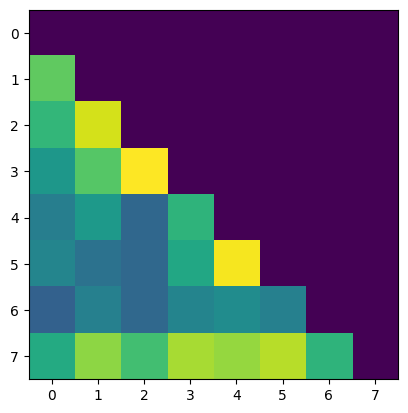

In [19]:
lan = LongRecordingAnalyzer(lrec, 10)
print(lan.n_fragments, lan.n_channels)

lan.setup_njobs()
mags = []
phases = []

for i in range(lan.n_fragments):
# for i in range(lan.n_fragments - 5, lan.n_fragments):
    if i == 20:
        break
    t = time.process_time()

    # lan.compute_nspike(i)
    # csd = lan.compute_csd(i)
    # plt.imshow(csd['alpha'])

    coh = lan.compute_cohere(i)
    print(coh)
    plt.imshow(coh['gamma'])

    # pcorr = lan.compute_pcorr(i)
    # plt.imshow(pcorr)

    # cacoh = lan.compute_cacoh(i, indices=([[1]], [[6]]))
    # plt.plot(cacoh[2], cacoh[0])
    # plt.plot(cacoh[2], cacoh[1])

    # cacoh = lan.compute_cacoh(i, freq_res=1, indices=([[0,1,2,3]], [[4,5,6,7]]))
    # mags.append(cacoh[0])
    # phases.append(cacoh[1])

    # lan.compute_rms(i)
    # lan.compute_ampvar(i)
    # f, psd = lan.compute_psd(i)
    # lan.compute_psdband(i, f_psd=(f, psd))
    # lan.compute_psdtotal(i, f_psd=(f, psd))
    # mb = lan.compute_psdslope(i, f_psd=(f, psd))
    # lan.compute_cohere(i)
    # corr = lan.compute_envcorr(i)

    # fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    # ax[0].imshow(corr)
    # ax[1].imshow(pcorr)
    # plt.show()

    print(time.process_time() - t)
    
# _, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True)
# mags = np.stack(mags, axis=-1).mean(axis=-1)
# phases = np.stack(phases, axis=-1).mean(axis=-1)
# ax[0].semilogx(cacoh[2], mags.transpose())
# ax[1].semilogx(cacoh[2], phases.transpose(), c='C1')
# ax[0].set_title("Magnitude")
# ax[1].set_title("Phase")
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(8, 3))
# ax.loglog(f, psd)
# for i, (m,b) in enumerate(mb):
#     ax.plot(f, 10**(b + m * np.log10(f)), c=f'C{i}')
# ax.set_ylabel("PSD (uV^2/Hz)")
# ax.set_xlabel("Frequency (Hz)")
# ax.axvline(60, c='black', ls='--', alpha=0.25)
# plt.show()


In [27]:
# Computationally heavy tests
# lan.compute_spikes() 
# lan.compute_wavetemp()
lan.compute_nspike(10) # Will autotrigger compute_spikes
wt, wts = lan.get_temps_from_wavetemp()

for wtch in wts:
    if wtch is not None:
        print(wtch.shape)
    else:
        continue
    fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
    for i in range(wtch.shape[0]):
        ax.plot(wtch[i, :, :])


No units across all channels, skipping..


AttributeError: 'LongRecordingAnalyzer' object has no attribute 'get_temps_from_wavetemp'

## Test PygWalker

## Set Up GUI

In [14]:
%%script false
class MainWindow(qw.QMainWindow): # TODO write GUI for application
    def __init__(self):
        super().__init__()

        self.setWindowTitle("Python EEG")

        self.label = qw.QLabel()
        self.input = qw.QLineEdit()
        self.input.textChanged.connect(self.label.setText)


        self.mat_button = qw.QPushButton("Open .MAT Folder")
        self.mat_pathdialog = qw.QFileDialog()
        self.mat_pathlabel = qw.QLabel("(No directory selected)")
        self.mat_directory = None
        
        self.mat_button.clicked.connect(self.select_mat_directory)


        # self.mat_button.clicked.connect(self.mat_pathdialog.getExistingDirectory)
        # self.mat_pathdialog.urlSelected.connect(self.set_mat_directory)
        # self.mat_pathdialog.
        # self.mat_pathdialog.directoryUrlEntered.connect(self.mat_pathlabel.setText)
        # self.mat_pathdialog.currentUrlChanged.connect(self.mat_pathlabel.setText)
        



        # self.button = qw.QPushButton("Button to open html...")
        # self.button.clicked.connect(self.open_html_window)
        
        # self.browser = qweb.QWebEngineView()
        # self.html = teststring
        # url = qc.QUrl.fromLocalFile(r"/mnt/isilon/marsh_single_unit/PythonEEG/html_pyg_walker.html")
        # self.browser.setUrl(url)
        # self.browser.loadProgress.connect(self.log_loading_progress)
        # self.browser.loadFinished.connect(self.log_loading_finished)


        layout = qw.QVBoxLayout()
        layout.addWidget(self.input)
        layout.addWidget(self.label)
        layout.addWidget(self.mat_button)
        layout.addWidget(self.mat_pathlabel)

        container = qw.QWidget()
        container.setLayout(layout)

        self.setCentralWidget(container)
    
    # def set_mat_directory(self, e):
    #     self.mat_directory = e
    #     print(e)
        # self.mat_pathlabel.setText(e)
    
    def select_mat_directory(self):
        filedialog = qw.QFileDialog()
        self.mat_directory = filedialog.getExistingDirectory(self, "Open Directory")
        self.mat_pathlabel.setText(self.mat_directory)



    def log_loading_progress(self, e):
        print(e)

    def log_loading_finished(self, e):
        print(e)

    # def set_matlab_path(self):
    #     print("Yes")



NameError: name 'qw' is not defined

In [ ]:
%%script false
app = qc.QCoreApplication.instance()
if app is None:
    app = qw.QApplication(sys.argv)

window = MainWindow()
window.show()

app.exec()


# export XDG_RUNTIME_DIR=/run/user/1028484

# export XDG_RUNTIME_DIR=/run/user/$UID 
# source ~/.bashrc